In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr

from datetime import date
import os
from scipy.io import loadmat
# load preset parameter values
from forecast_conf import (model_directory,x_location,y_location,range_pixels,target_lead_time,extra_data_lead_times,test_forecasts_per_set,test_time_1,test_time_2)
# import functions
from helper_functions import standardize_dims

In [2]:
# set parameters, if different than in forecast_conf

# location of data
x_location=271.5
y_location=28.19

# size of image to consider, in +/- from data location, in number of pixels
range_pixels=25

# which lead time to train on
target_lead_time=30

# how many extra data points to take on either side of the desired lead time, in order to increase data points
# note that forecasts are issued every week, so shouldn't use more 6 days before/after
extra_data_lead_times = 2

# number of forecasts tested per batch, we take two batches
test_forecasts_per_set=3

# first forecasts of each batch
test_time_1=27
test_time_2=35

# stack together in array
test_indeces=np.array([range(test_time_1,test_time_1+test_forecasts_per_set),range(test_time_2,test_time_2+test_forecasts_per_set)])
test_indeces = test_indeces.astype(int)

In [3]:
# load measurements from mat file
# C is current speed
# T is time
C = loadmat('TH_current_ADCP.mat')['C'].squeeze()
T = loadmat('TH_current_ADCP.mat')['T'].squeeze()

In [4]:
import datetime
# convert matlab times to datetime
pdate=pd.to_datetime(T-719529,unit='d').round('s').values


In [5]:
# put current measurements into an xarray for ease of use and re-time to daily mean
measurements= xr.Dataset({"Speed": (["time"], C)},coords={"time": pdate})
# retime to 2h means
measurements=measurements.resample(time="2H").mean()


/opt/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [6]:
''''''''''
Now, get a list of directories with forecast data.

The data is structured such that each forecast is in one directory, 
and within each directory there is a netcdf file for each lead time, a week apart (usually 46 files)

'''''''''
ls=[x[0] for x in os.walk('.')]
forecast_directories=[]
for x in ls:
    # forecast folders are labelled by date, so have "20" in the name
    if x.find('20') > 0:
        forecast_directories.append(x)

In [7]:
# make a list of all forecast files across all directories
forecast_file_list=[]

for y in forecast_directories:
    temp=[x[2] for x in os.walk(y)]
    for m in temp[0]:
        if m.find('.nc') > 0:
            forecast_file_list.append(y+'/'+m)     
            
# sort the list of all files            
forecast_file_list.sort()

# count total number of forecast used
number_of_forecasts=len(forecast_directories)



In [8]:
from datetime import datetime, timedelta


# create arrays to hold X and Y values for CNN
# dimensions are:
# Dims: (forecast, lead times within within forecast, number of ensemble members, x-pixels, y-pixels, number of fields)
X_data=np.empty((number_of_forecasts,1+2*extra_data_lead_times,32,2*range_pixels,2*range_pixels,4))

# Dims: (forecast, lead times within within forecast, number of ensemble members)
Y_data=np.empty((number_of_forecasts,1+2*extra_data_lead_times,32))


# parameters used for indexing
directory_index=0

current_directory=forecast_file_list[0][2:10]


# get indices for (x,y) measurement location
arr=xr.open_dataset(forecast_file_list[0])
arr=standardize_dims(arr)
lat=abs(arr.lat-y_location)
lon=abs(arr.lon-x_location)
y_location_index=np.argmin(lat.values)
x_location_index=np.argmin(lon.values)

In [9]:
# load the data in the correct format
for k in forecast_file_list:
    # check if moving to new forecast, and update current_directory if so
    if k[2:10] != current_directory:
        directory_index+=1
        current_directory=k[2:10]
        
    # calculate forecast lead time, in days
    # date of issue
    date1 = datetime.strptime(k[24:32], '%Y%m%d')
    # date of prediction
    date2 = datetime.strptime(k[33:41], '%Y%m%d')
    # lead time
    days_difference=(date2-date1).days
    
    # only save data if it is used for training, which is defined by main lead time, and +/- chosen days
    if days_difference<=(target_lead_time+extra_data_lead_times) and days_difference>=(target_lead_time-extra_data_lead_times):
    
        arr=xr.open_dataset(k)
        arr=standardize_dims(arr)
        # load sea surface temperature
        t=arr.water_temp_mb.squeeze()
        # load current speed
        s=100*np.sqrt(arr.water_u_mb**2+arr.water_v_mb**2).squeeze()
        # load current direction
        ddir = np.arctan2(arr.water_u_mb, arr.water_v_mb).squeeze()
        # select (x,y) window
        t=t[:,y_location_index-range_pixels:y_location_index+range_pixels,x_location_index-range_pixels:x_location_index+range_pixels]
        s=s[:,y_location_index-range_pixels:y_location_index+range_pixels,x_location_index-range_pixels:x_location_index+range_pixels]
        ddir=ddir[:,y_location_index-range_pixels:y_location_index+range_pixels,x_location_index-range_pixels:x_location_index+range_pixels]
        # calculate ensemble means
        tm=t.mean(dim='ENSEMBLE')
        sm=s.mean(dim='ENSEMBLE')
        ddirm=ddir.mean(dim='ENSEMBLE')
    
        # get measurement at correct lead time
        val=measurements.sel(time=pd.to_datetime(date2), method="nearest").Speed.values


        for k in range(32):

            # put data into the array used for training and testing
            # here, you can choose which fields to use (speed, direction, seas surface temperature)
            # potential to add other measurement, and/or reanalyses fields such as wind, in the future
            # this should be vectorized, but there are some directories with less than 46 files
            X_data[directory_index,days_difference-(target_lead_time-extra_data_lead_times),k,:,:,0]=s[k%s.shape[0],:,:].values
            X_data[directory_index,days_difference-(target_lead_time-extra_data_lead_times),k,:,:,1]=sm.values
            #X_data[directory_index,days_difference-(target_lead_time-extra_data_lead_times),k,:,:,2]=ddir[k%s.shape[0],:,:].values
            #X_data[directory_index,days_difference-(target_lead_time-extra_data_lead_times),k,:,:,3]=ddirm.values           
            X_data[directory_index,days_difference-(target_lead_time-extra_data_lead_times),k,:,:,2]=t[k%s.shape[0],:,:].values
            #X_data[directory_index,days_difference-(target_lead_time-extra_data_lead_times),k,:,:,3]=tm.values                  
            X_data[directory_index,days_difference-(target_lead_time-extra_data_lead_times),k,:,:,3]=date2.month
        
        # create y-values dataset    
        for k in range(32):
            # read predicted current at measurement location
            mod=s[k%s.shape[0],:,:].sel(lon=271.5,lat=28.19, method="nearest").squeeze().values
            # save error for each ensemble member
            Y_data[directory_index,days_difference-(target_lead_time-extra_data_lead_times),k]=val-mod
  
 
    
    

In [10]:
# define index of forecasts
Index_forecast= [x for x in range(number_of_forecasts*(1+2*extra_data_lead_times)*32)]
Index_forecast=np.array(Index_forecast)
Index_forecast=Index_forecast.reshape(number_of_forecasts,1+2*extra_data_lead_times,32)



Text(0, 0.5, '[m/s]')

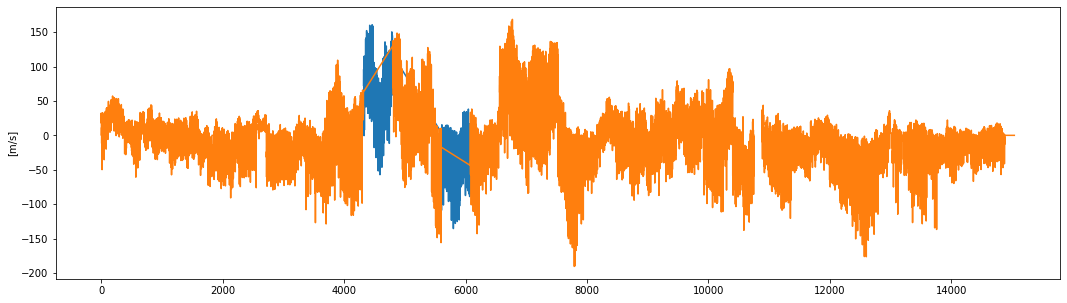

In [11]:
'''''''''
Split the data into test and train, and visualize.


Normally, I would select random forecasts to test on, which can easily be done.
However, in this case I want to make sure that the trained model can handle cases where the forecast 
vastly underestimates the measured current, and where it vastly overestimates the current
This does mean that less data in each case is used to train the mode, but this will improve as more data is collected.

'''''''''

# index for number of true errors
I=range(0,Y_data.shape[0])

# predefine arrays
X_data_test=np.empty((2,test_forecasts_per_set,1+2*extra_data_lead_times,32,2*range_pixels,2*range_pixels,4))
Y_data_test=np.empty((2,test_forecasts_per_set,1+2*extra_data_lead_times,32))

# split the test data into two cases (overestime and underestimates)
for k in range(2):
    X_data_test[k,:,:,:,:]=X_data[test_indeces[k,:],:,:,:,:]
    Y_data_test[k,:,:]=Y_data[test_indeces[k,:],:,:]

# for a last test, I want to test the model on ONLY the targeted lead time (not +/- the day chosen before)
X_data_final=X_data[test_indeces.flatten(),extra_data_lead_times,:,:,:]
Y_data_final=Y_data[test_indeces.flatten(),extra_data_lead_times,:]

I_train=range(number_of_forecasts)
I_train=np.delete(I,test_indeces.flatten())

# populate arrays
X_data_train=X_data[I_train,:,:,:,:]
Y_data_train=Y_data[I_train,:,:]


X_data_test=X_data_test.reshape(2,np.array(X_data_test.shape[1:4]).prod(),2*range_pixels,2*range_pixels,4)
Y_data_test=Y_data_test.reshape(2,np.array(Y_data_test.shape[1:4]).prod(),1)

X_data_train=X_data_train.reshape(np.array(X_data_train.shape[:3]).prod(),2*range_pixels,2*range_pixels,4)
Y_data_train=Y_data_train.reshape(np.array(Y_data_train.shape[:3]).prod(),1)

# plot all the data and highlight the forecasts used for testing
plt.figure(figsize=(18,5))
plt.plot(Index_forecast[test_indeces.flatten(),:,:].flatten(),Y_data_test.flatten())
plt.plot(Index_forecast[I_train,:,:].flatten(),Y_data_train)
plt.ylabel('[m/s]')

In [12]:
# shuffle training data
p = np.random.permutation(X_data_train.shape[0])
X_data_train=X_data_train[p,:,:,:]
Y_data_train=Y_data_train[p,:,]
I = np.argwhere(~np.isnan(Y_data_train) & ~np.isinf(Y_data_train))[:,0]
X_data_train=X_data_train[I,:,:,:]
Y_data_train=Y_data_train[I,:]



In [48]:
# build tensorflow CNN model
import tensorflow as tf

from tensorflow.keras import datasets, layers, models, regularizers
import matplotlib.pyplot as plt

model = models.Sequential()
model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(2*range_pixels,2*range_pixels, 4)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))


In [49]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 48, 48, 8)         296       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 24, 24, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 22, 22, 16)        1168      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 11, 11, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 9, 9, 32)          4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)              

In [50]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [51]:
history = model.fit(X_data_train, Y_data_train, epochs=30,validation_split = 0.05,batch_size=50)
# Save the weights
model.save_weights(model_directory)

Epoch 1/30
264/264 [==============================] - 30s 105ms/step - loss: 1694.4617 - val_loss: 1416.2695
Epoch 2/30
264/264 [==============================] - 29s 108ms/step - loss: 1506.9496 - val_loss: 1185.6268
Epoch 3/30
264/264 [==============================] - 28s 104ms/step - loss: 1365.6782 - val_loss: 1126.3966
Epoch 4/30
264/264 [==============================] - 18s 68ms/step - loss: 1295.5376 - val_loss: 1121.6044
Epoch 5/30
264/264 [==============================] - 17s 66ms/step - loss: 1234.7308 - val_loss: 1076.6624
Epoch 6/30
264/264 [==============================] - 27s 101ms/step - loss: 1206.9403 - val_loss: 1016.2275
Epoch 7/30
264/264 [==============================] - 28s 105ms/step - loss: 1127.4046 - val_loss: 964.1569
Epoch 8/30
264/264 [==============================] - 24s 91ms/step - loss: 1180.9545 - val_loss: 928.9728
Epoch 9/30
264/264 [==============================] - 26s 99ms/step - loss: 1073.1790 - val_loss: 799.2159
Epoch 10/30
264/264 [=====

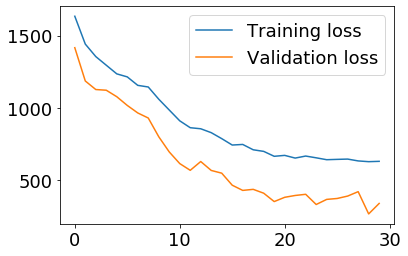

In [56]:
# plot losses
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

Test period 1:
Mean model error raw: 87.1 +/- 39.8
Mean model error calibrated: 63.2 +/- 24.7
Test period 2:
Mean model error raw: -24.0 +/- 34.2
Mean model error calibrated: -9.9 +/- 24.7


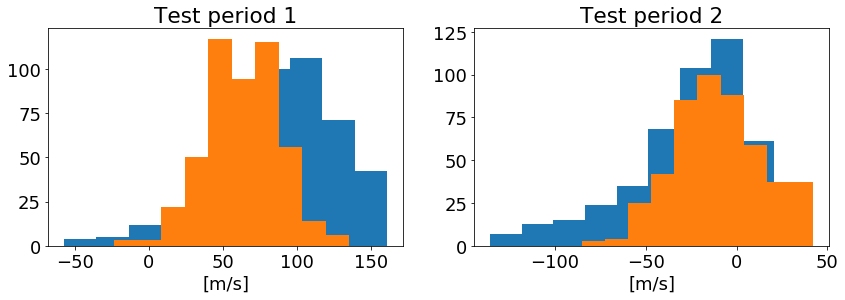

In [57]:
# Test model on unseen, un-shuffled data 
model.load_weights(model_directory)
fig, axs = plt.subplots(1,2, figsize=(14, 4), facecolor='w', edgecolor='k')
axs = axs.ravel()

for k in range(2):
    axs[k].hist(Y_data_test[k,:,:])
    P=model.predict(X_data_test[k,:,:,:,:])
    axs[k].hist(Y_data_test[k,:,:]-P)
    axs[k].title.set_text('Test period '+str(k+1))
    axs[k].set_xlabel('[m/s]')
    print('Test period '+str(k+1)+':')
    print('Mean model error raw: ' + str('%.1f' % np.nanmean(Y_data_test[k,:,:]))+ ' +/- '+str( '%.1f' %np.nanstd(Y_data_test[k,:,:])))
    print('Mean model error calibrated: ' + str( '%.1f' %np.nanmean(Y_data_test[k,:,:]-P))+ ' +/- '+str( '%.1f' %np.nanstd(Y_data_test[k,:,:]-P)))


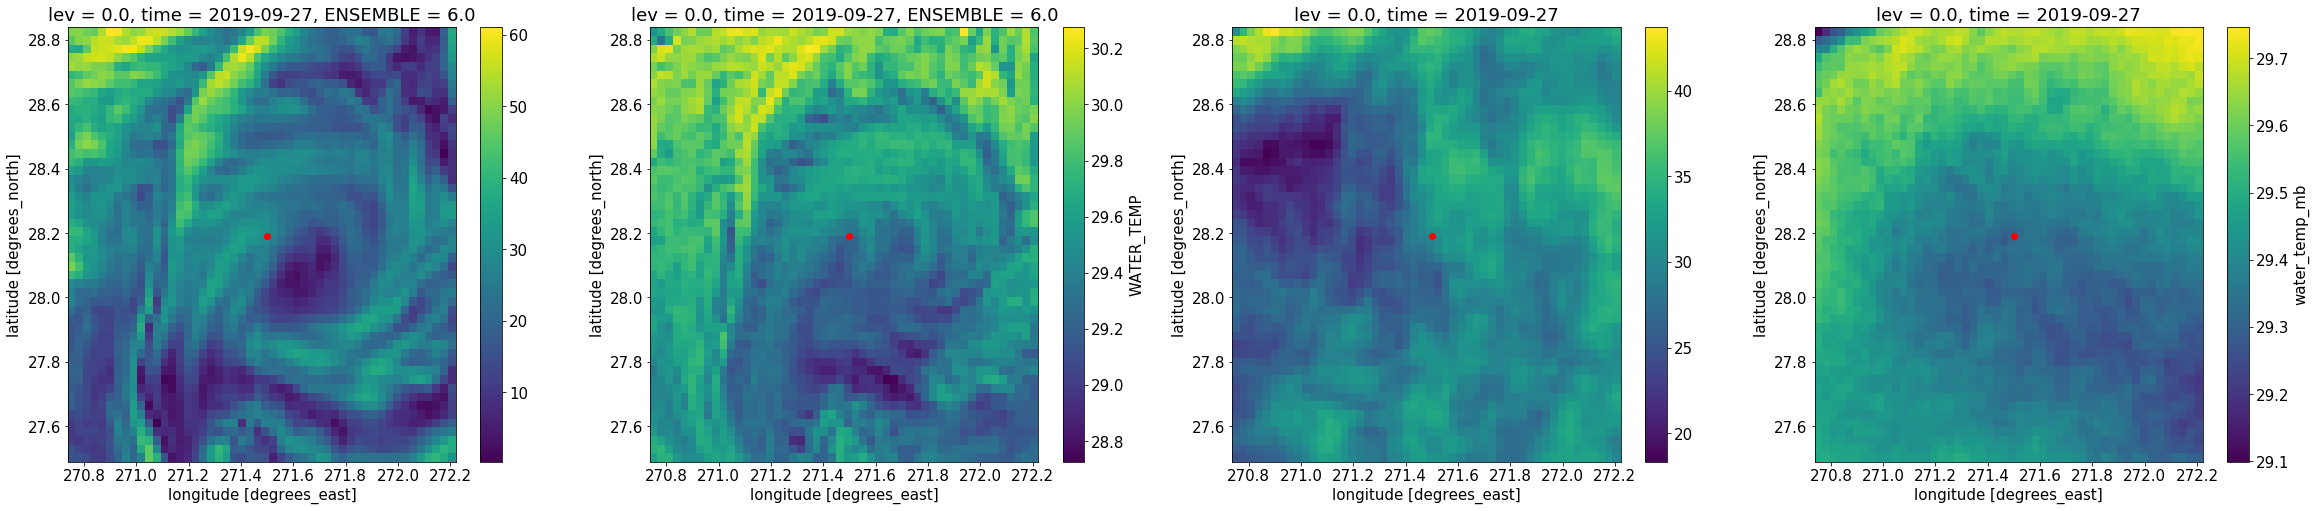

In [58]:
# plot some example images going into the CNN
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(40,8))
plt.subplot(141)
s[5,:,:].plot()
plt.plot(271.5,28.19,'ro')
plt.subplot(142)
t[5,:,:].plot()
plt.plot(271.5,28.19,'ro')
plt.subplot(143)
sm[:,:].plot()
plt.plot(271.5,28.19,'ro')
plt.subplot(144)
tm[:,:].plot()
plt.plot(271.5,28.19,'ro')
plt.savefig('./example_input.png')

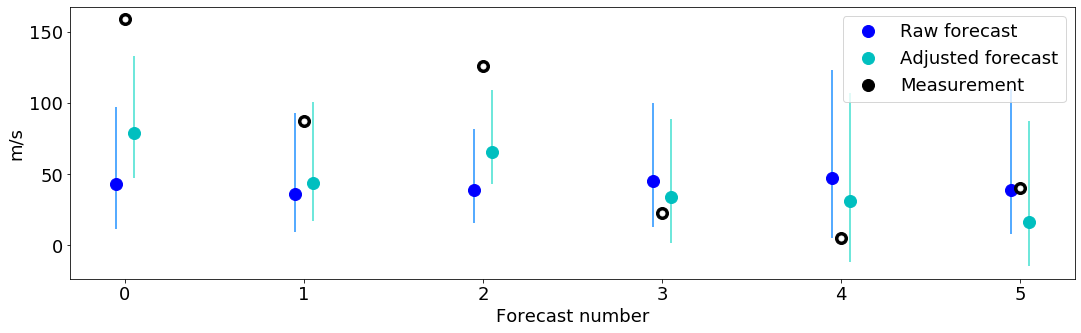

In [59]:
# finally, plot what predicted error from the CNN model would do to the unseen forecasts
# Here, we use the mean of the corrected forecast to adjust the mean of the raw forecast
# Since the CNN model is trained to bias correct individual ensemble members, it changes the spread of the forecast.
# The spread off the CNN-corrected ensemble is not calibrated, whereas the spread of the raw model is, so we
# keep the ensemble spread of the raw forecast but correct the mean
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(18,5))
for k in range(X_data_final.shape[0]):
    p=X_data_final[k,:,range_pixels,range_pixels,0]
    pc=model.predict(X_data_final[k,:,:,:,:])
    measured_data=Y_data_final[k,:]+p
    plt.plot((k-0.05),np.mean(p),'bo', markersize=12, label='Raw forecast')
    
    plt.plot((k+0.05),np.mean(p+np.mean(pc)),'co', markersize=12, label='Adjusted forecast')
    p1=np.percentile(p,5)
    p2=np.percentile(p,95)
    err=np.empty((2,1))
    err[0,0]=abs(p1-np.mean(p))
    err[1,0]=p2-np.mean(p)
    plt.errorbar((k+0.05),np.mean(p+np.mean(pc)),yerr=err,ecolor='turquoise')
    plt.errorbar((k-0.05),np.mean(p),yerr=err,ecolor='dodgerblue')
    plt.plot(k,measured_data[0],'ko', markersize=12, label='Measurement')
    plt.plot(k,measured_data[0],'wo', markersize=5)
plt.xlabel('Forecast number')
plt.ylabel('m/s')
plt.legend(['Raw forecast', 'Adjusted forecast', 'Measurement'])
plt.savefig('./forecast_adj_test.png')